# Demo File
This demo tests the functionality of the EchoStateNetwork with different time series

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from ESN import EchoStateNetwork,GinfActivator, visualize_reservoir, BandPassNetwork

ginf_activator = GinfActivator(V_min=-2, V_max=2, resolution=200, offset=True)


def mse(test, predictions):
    return np.mean((predictions - test) ** 2)

def nrmse(test, predictions):
    return np.sqrt(np.mean((predictions - test) ** 2))/(max(test.T[0])-min(test.T[0]))

In [3]:
def MackeyGlassGenerator(tau=17, n=1000, beta=0.2, gamma=0.1, n_samples=5000, dt=1.0, seed=None):
    """
    Generate Mackey-Glass time series
    Parameters:
    tau (int): Time delay
    n (int): Number of points to generate
    beta, gamma (float): Equation parameters
    n_samples (int): Number of samples to keep
    dt (float): Time step size
    """
    if seed:
        np.random.seed(seed)

    history_len = tau * 1
    values = np.random.rand(history_len + n)

    #values[:history_len] = 1.1

    delay_steps = int(tau / dt)
    if delay_steps <= 0:
        delay_steps = 1

    for t in range(history_len, history_len + n - 1):
        x_tau = values[t - delay_steps]
        dx_dt = beta * x_tau / (1 + x_tau**10) - gamma * values[t]
        values[t + 1] = values[t] + dx_dt * dt

    return values[history_len : history_len + n_samples]

## Steady State Conductance Activator

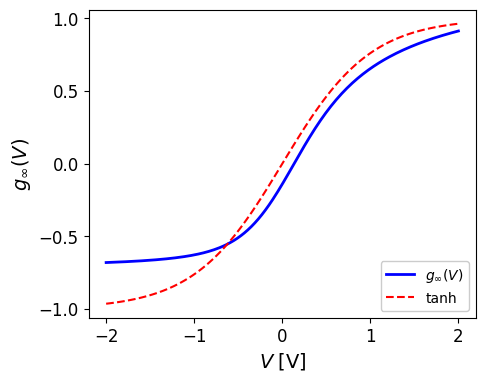

In [4]:
lookup_table = ginf_activator.get_lookup_table()

in_array = np.linspace(-2, 2, 100) 
out_array = np.tanh(in_array) 

plt.figure(figsize=(5, 4))
plt.plot(
    lookup_table[0],
    lookup_table[1],
    label=r"$g_{\infty}(V)$",
    color="blue",
    linewidth=2,
)
plt.plot(in_array, out_array, linestyle="--",label="tanh", alpha=1, color='red')
plt.xlabel(r"$V \;[\text{V}]$", fontsize=14)
plt.ylabel(r"$g_{\infty}(V)$", fontsize=14)
#plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(np.arange(-2,2.5,1),fontsize=12)
plt.yticks(np.arange(-1,1.05,0.5),fontsize=12)
plt.legend(loc='lower right',framealpha=1)
plt.savefig("output/ginf_activator_plot.pdf",bbox_inches='tight')
plt.savefig("output/ginf_activator_plot.png",bbox_inches='tight')

## ESN with Mackey-Glass time series

In [5]:
# Generate Mackey-Glass time series
mg_dt = 1
mg_series = MackeyGlassGenerator(tau=17, n=100000, n_samples=50000, dt=mg_dt)

# Normalize data between -1 and 1
mg_series = 2 * (mg_series - mg_series.min()) / (mg_series.max() - mg_series.min()) - 1

# Create input/output pairs for time series prediction
inputs = mg_series[:-1].reshape(-1, 1)
targets = mg_series[1:].reshape(-1, 1)

# Split into train and test sets
train_len = 21000
test_len = 4000
train_inputs = inputs[:train_len]
train_targets = targets[:train_len]
test_inputs = inputs[train_len : train_len + test_len]
test_targets = targets[train_len : train_len + test_len]

In [6]:
mse_mean = 0
test_num = 20
for i in range(test_num):
    esn = EchoStateNetwork(
        input_dim=1,
        reservoir_size=400,
        output_dim=1,
        leaking_rate=0.9,
        step_size=mg_dt,
        time_scale=1/0.44,
        spectral_radius=0.95,
        sparsity=0.75,
        input_scaling=0.5,
        regularization=1e-6,
        washout = round(train_len/400),
        activation=ginf_activator.activate,
        guarantee_ESP=False,
        progress_bar=False,
    )
    
    # Train on first part of series
    esn.fit(train_inputs, train_targets)
    
    # Generate predictions on test set
    teacher_ratio = 0.2
    predictions_mg = esn.predict(test_inputs, teacher_ratio=teacher_ratio)

    mse_mean += (test_targets[883,0]-predictions_mg[883,0])**2/test_num
    
# Calculate prediction error after network settled from np.zeroes initialization
rmse_mean = np.sqrt(mse_mean)

#print(f"{nrmse(test_targets, predictions) = }")
print('{0:.16f}'.format(rmse_mean))
print(f"{esn.physical_length = }")
teacher_mode = int(len(test_targets)*teacher_ratio)
print(f"{teacher_mode = } out of {len(test_targets)}")

This initilization might not have the echo state property
0.0009254844980355
esn.physical_length = np.float64(174.07765595569788)
teacher_mode = 800 out of 4000


In [7]:
bpn = BandPassNetwork(
    input_dim=1,
    reservoir_size=100,
    output_dim=1,
    leaking_rate=0.9,
    step_size=mg_dt,
    time_scale=1/0.45,
    time_scale_std=0.4,
    spectral_radius=0.9,
    sparsity=0.85,
    input_scaling=0.5,
    regularization=1e-6,
    washout = round(train_len/400),
    activation=ginf_activator.activate,
    guarantee_ESP=False,
)

# Train on first part of series
bpn.fit(train_inputs, train_targets)

# Generate predictions on test set
teacher_ratio = 0.2
predictions = bpn.predict(test_inputs, teacher_ratio=teacher_ratio)

# Calculate prediction error after network settled from np.zeroes initialization
print(f"{mse(test_targets, predictions) = }")

print(f"{esn.physical_length = }")
teacher_mode = int(len(test_targets)*teacher_ratio)
print(f"{teacher_mode = } out of {len(test_targets)}")

This initilization might not have the echo state property


Training (time-step):   0%|          | 0/21052 [00:00<?, ?it/s]

Training (time-step): 100%|██████████| 21052/21052 [00:00<00:00, 111670.86it/s]

mse(test_targets, predictions) = np.float64(0.19659974275811723)
esn.physical_length = np.float64(174.07765595569788)
teacher_mode = 800 out of 4000


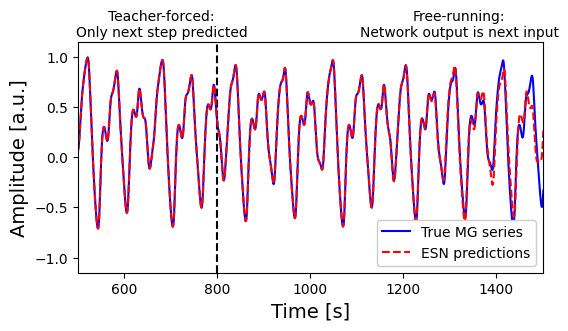

In [8]:
cutoff_min = 500
cutoff_max = 1500

plt.figure(figsize=(6, 3))
plt.axvline(x=teacher_mode, linestyle="--", color='black')
plt.text(cutoff_min+180, 1.2, 'Teacher-forced:\nOnly next step predicted', dict(size=10), horizontalalignment='center')
plt.text(cutoff_max-180, 1.2, 'Free-running:\nNetwork output is next input', dict(size=10), horizontalalignment='center')
plt.plot(test_targets, label="True MG series", alpha=1, color='blue')
plt.plot(predictions_mg, label="ESN predictions", linestyle="--", alpha=1, color='red')
# plt.title("Mackey-Glass Time Series Prediction (First 400 Steps)")
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Amplitude [a.u.]", fontsize=14)
plt.xlim(cutoff_min, cutoff_max)
plt.ylim(-1.15, 1.15)
plt.legend(loc='lower right',framealpha=1)
plt.savefig("output/mg_prediction_plot.pdf",bbox_inches='tight')
plt.savefig("output/mg_prediction_plot.png",bbox_inches='tight')

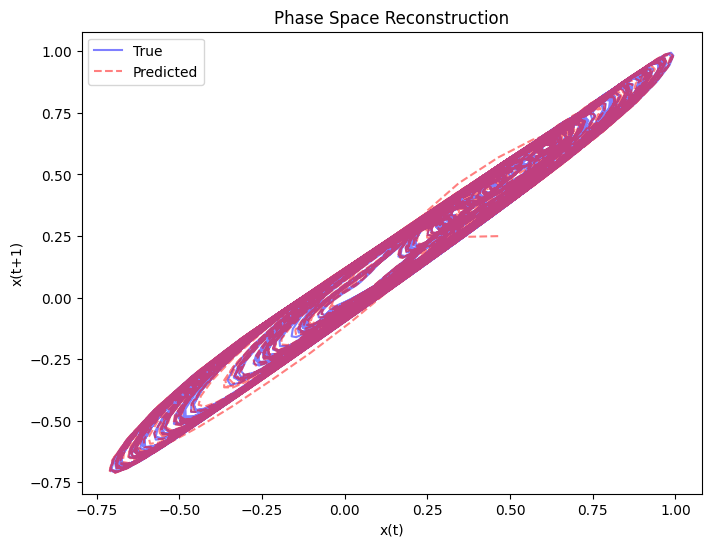

In [9]:
# Plot phase space reconstruction
plt.figure(figsize=(8, 6))
plt.plot(
    test_targets[:-1][:5000],
    test_targets[1:][:5000],
    "b-",
    alpha=0.5,
    label="True",
)
plt.plot(
    predictions_mg[:-1][:5000],
    predictions_mg[1:][:5000],
    "r--",
    alpha=0.5,
    label="Predicted",
)
plt.title("Phase Space Reconstruction")
plt.xlabel("x(t)")
plt.ylabel("x(t+1)")
plt.legend()
plt.savefig("output/mg_phase_space_plot.pdf")
plt.savefig("output/mg_phase_space_plot.png")

In [10]:
#visualize_reservoir(esn)

## ESN with Harmonic Wave time series

In [12]:
# Generate synthetic data (simple sine wave prediction)
t = np.linspace(0, 80 * np.pi, 800)
time_scale_harmonic = 80 * np.pi/800
data = np.sin(t) * np.cos(1.4*t)

# Create input/output pairs for time series prediction
inputs = data[:-1].reshape(-1, 1)
targets = data[1:].reshape(-1, 1)

(-1.15, 1.15)

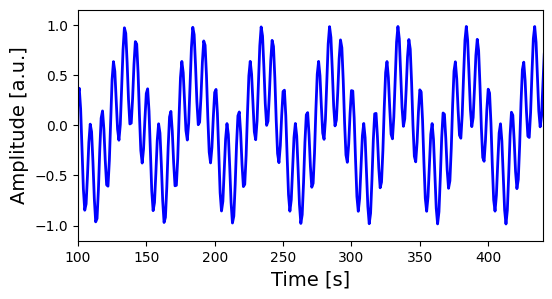

In [13]:
cutoff_min = 100
cutoff_max = 440

plt.figure(figsize=(6, 3))
plt.plot(targets, label="True signal",color='blue',linewidth=2)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Amplitude [a.u.]", fontsize=14)
plt.xlim(cutoff_min, cutoff_max)
plt.ylim(-1.15, 1.15)

In [14]:
# Generate synthetic data (simple sine wave prediction)
t = np.linspace(0, 80 * np.pi, 800)
dt_harmonic = 80 * np.pi/800
data_bpntest = np.sin(t) * np.cos(1.2*t)

# Create input/output pairs for time series prediction
inputs_bpntest = data_bpntest[:-1].reshape(-1, 1)
targets_bpntest = data_bpntest[1:].reshape(-1, 1)

(-1.15, 1.15)

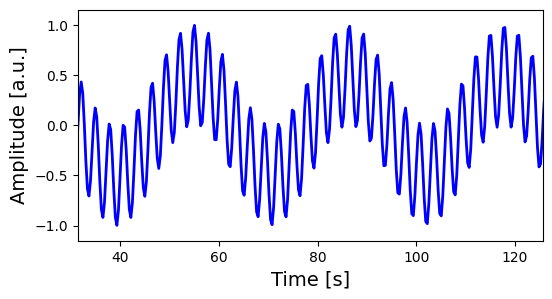

In [15]:
cutoff_min = 100*dt_harmonic
cutoff_max = 400*dt_harmonic

plt.figure(figsize=(6, 3))
plt.plot(t,data_bpntest, label="True signal",color='blue',linewidth=2)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Amplitude [a.u.]", fontsize=14)
plt.xlim(cutoff_min, cutoff_max)
plt.ylim(-1.15, 1.15)

In [42]:
# Simple harmonic ESN training

esn = EchoStateNetwork(
    input_dim=1,
    reservoir_size=25,
    output_dim=1,
    leaking_rate=0.9,
    step_size=dt_harmonic,
    time_scale=1,
    spectral_radius=0.8,
    sparsity=0.75,
    input_scaling=0.1,
    regularization=1e-6,
    washout=0,
    activation=ginf_activator.activate,
    progress_bar=False,
)

# Train on synthetic data
esn.fit(inputs, targets)

# Generate predictions
teacher_ratio=0.25
predictions_simpleharmonic = esn.predict(inputs, teacher_ratio=teacher_ratio)
print(f"{esn.physical_length = }")

# Calculate prediction error after network settled from np.zeroes initialization
print(f"{np.sqrt(mse(targets, predictions_simpleharmonic)) = }")

esn.physical_length = np.float64(115.47005383792515)
np.sqrt(mse(targets, predictions_simpleharmonic)) = np.float64(0.17905886741176957)


In [43]:
# Initialize and train ESN
bpn = BandPassNetwork(
    input_dim=1,
    reservoir_size=15,
    output_dim=1,
    leaking_rate=0.9,
    step_size=time_scale_harmonic,
    time_scale=4,
    time_scale_std=3,
    spectral_radius=0.8,
    sparsity=0.75,
    input_scaling=0.5,
    regularization=1e-6,
    washout=0,
    activation=ginf_activator.activate,
    weight_seed = 1,
)

# Train on synthetic data
bpn.fit(inputs, targets)

# Generate predictions
teacher_ratio=0.25
bpn_predictions = bpn.predict(inputs, teacher_ratio=teacher_ratio)

# Calculate prediction error after network settled from np.zeroes initialization
print(f"{mse(targets, bpn_predictions) = }")

teacher_mode = int(len(targets)*teacher_ratio)
print(f"{teacher_mode = } out of {len(targets)}")

Training (time-step): 100%|██████████| 799/799 [00:00<00:00, 99873.31it/s]

mse(targets, bpn_predictions) = np.float64(0.1238751667048191)
teacher_mode = 199 out of 799


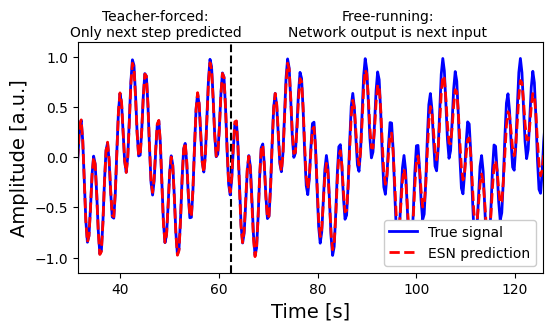

In [44]:
cutoff_min = 100*dt_harmonic
cutoff_max = 400*dt_harmonic

plt.figure(figsize=(6, 3))
plt.axvline(x=teacher_mode*dt_harmonic, linestyle="--", color='black')
plt.text(cutoff_min+50*dt_harmonic, 1.2, 'Teacher-forced:\nOnly next step predicted', dict(size=10), horizontalalignment='center')
plt.text(cutoff_max-100*dt_harmonic, 1.2, 'Free-running:\nNetwork output is next input', dict(size=10), horizontalalignment='center')
plt.plot(t,data, label="True signal",color='blue',linewidth=2)
plt.plot(t[1:],predictions_simpleharmonic.T[0], label="ESN prediction", linestyle="--",color='red',linewidth=2)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Amplitude [a.u.]", fontsize=14)
plt.xlim(cutoff_min, cutoff_max)
plt.ylim(-1.15, 1.15)
plt.legend(loc='lower right',framealpha=1)
plt.savefig("output/harmonic_prediction_plot.pdf",bbox_inches='tight')
plt.savefig("output/harmonic_prediction_plot.png",bbox_inches='tight')

In [45]:
# Initialize and train ESN
mse_mean = 0
test_num = 100
for i in range(test_num):
    esn = EchoStateNetwork(
        input_dim=1,
        reservoir_size=12,
        output_dim=1,
        leaking_rate=0.9,
        step_size=dt_harmonic,
        time_scale=1,
        spectral_radius=0.8,
        sparsity=0.75,
        input_scaling=0.1,
        regularization=1e-6,
        washout=0,
        activation=ginf_activator.activate,
        progress_bar=False,
        guarantee_ESP=True,
    )
    
    # Train on synthetic data
    esn.fit(inputs_bpntest, targets_bpntest)
    
    # Generate predictions
    teacher_ratio=0.25
    predictions = esn.predict(inputs_bpntest, teacher_ratio=teacher_ratio)
    mse_mean += (targets_bpntest[375,0]-predictions[375,0])**2/test_num
    # Calculate prediction error after network settled from np.zeroes initialization
    #print(f"{mse(targets, predictions) = }")

rmse_mean_harmonic_esn = np.sqrt(mse_mean)
teacher_mode = int(len(targets_bpntest)*teacher_ratio)
print(f"{teacher_mode = }")
print(rmse_mean_harmonic_esn)

teacher_mode = 199
126.91294637410063


In [53]:
# Initialize and train BPN
mse_mean = 0
test_num = 100
for i in range(test_num):
    bpn = BandPassNetwork(
        input_dim=1,
        reservoir_size=12,
        output_dim=1,
        leaking_rate=0.9,
        step_size=dt_harmonic,
        time_scale=2,
        time_scale_std=5,
        spectral_radius=0.8,
        sparsity=0.75,
        input_scaling=0.1,
        regularization=1e-6,
        washout=0,
        activation=ginf_activator.activate,
        weight_seed = 1,
        progress_bar=False,
    )
    # Train on synthetic data
    bpn.fit(inputs_bpntest, targets_bpntest)
    
    # Generate predictions
    teacher_ratio=0.25
    bpn_predictions = bpn.predict(inputs_bpntest, teacher_ratio=teacher_ratio)
    mse_mean += (targets_bpntest[375,0]-bpn_predictions[375,0])**2/test_num
    # Calculate prediction error after network settled from np.zeroes initialization
    #print(f"{mse(targets, bpn_predictions) = }")

rmse_mean_harmonic_bpn = np.sqrt(mse_mean)
teacher_mode = int(len(targets_bpntest)*teacher_ratio)
print(f"{teacher_mode = }")
print(rmse_mean_harmonic_bpn)

teacher_mode = 199
0.2201761204004628


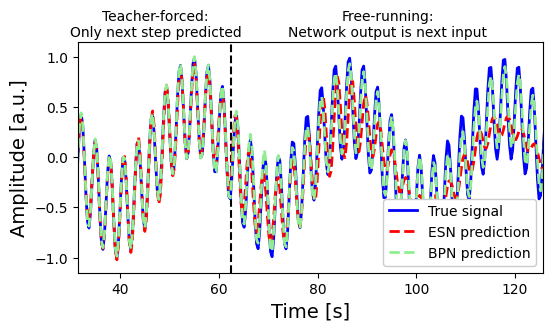

In [54]:
cutoff_min = 100*dt_harmonic
cutoff_max = 400*dt_harmonic

plt.figure(figsize=(6, 3))
plt.axvline(x=teacher_mode*dt_harmonic, linestyle="--", color='black')
plt.text(cutoff_min+50*dt_harmonic, 1.2, 'Teacher-forced:\nOnly next step predicted', dict(size=10), horizontalalignment='center')
plt.text(cutoff_max-100*dt_harmonic, 1.2, 'Free-running:\nNetwork output is next input', dict(size=10), horizontalalignment='center')
plt.plot(t,data_bpntest, label="True signal",color='blue',linewidth=2)
plt.plot(t[1:],predictions.T[0], label="ESN prediction", linestyle="--",color='red',linewidth=2)
plt.plot(t[1:],bpn_predictions.T[0], label="BPN prediction", linestyle="--",color='lightgreen',linewidth=2)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Amplitude [a.u.]", fontsize=14)
plt.xlim(cutoff_min, cutoff_max)
plt.ylim(-1.15, 1.15)
plt.legend(loc='lower right',framealpha=1)
plt.savefig("output/harmonic2_prediction_plot.pdf",bbox_inches='tight')
plt.savefig("output/harmonic2_prediction_plot.png",bbox_inches='tight')

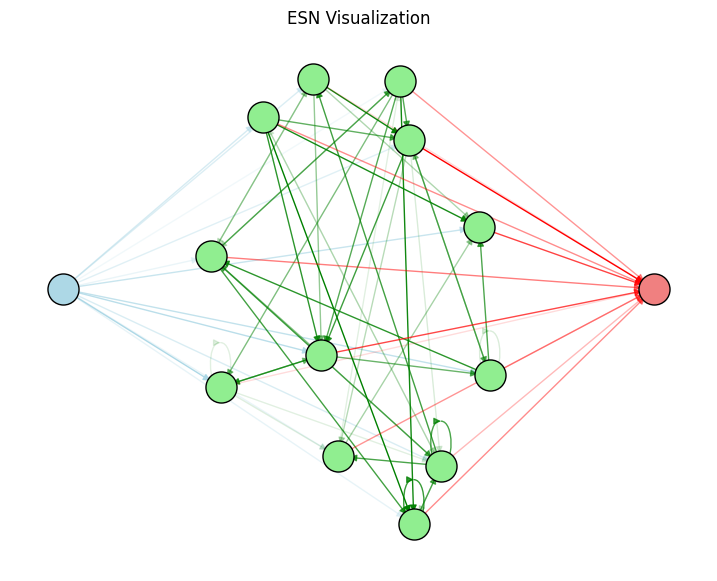

In [61]:
visualize_reservoir(bpn)

## ESN with Ventilator Pressure Prediction data

In [62]:
import pandas as pd
from ESN import BandPassNetwork

In [ ]:
data = pd.read_csv(r"data\ventilator-pressure-prediction\train.csv")[:100000]

#data = data.to_dummies(columns=["R", "C"])

split = int(len(data) * 0.8)
predict_steps = 3

train_x = data[["pressure"]][0:split-predict_steps].to_numpy()
train_y = data[["pressure"]][predict_steps:split].to_numpy()
test_x = data[["pressure"]][split:len(data)-predict_steps].to_numpy()
test_y = data[["pressure"]][split+predict_steps:len(data)].to_numpy()

#data.drop('id','breath_id',"pressure")[:split].head()

In [66]:
train_x_uout = data[["pressure"]][:split].to_numpy()
train_y_uout = data[["u_out"]][:split].to_numpy()
test_x_uout = data[["pressure"]][split:].to_numpy()
test_y_uout = data[["u_out"]][split:].to_numpy()

In [67]:
mse_mean = 0
test_num = 20
for i in range(test_num):
    esn = EchoStateNetwork(
        input_dim=train_x.shape[1],
        reservoir_size=28,
        output_dim=train_y.shape[1],
        leaking_rate=0.66,
        step_size=0.034035,
        time_scale=0.15,
        spectral_radius=0.16,
        sparsity=0.75,
        input_scaling=0.1,
        regularization=0.00047855525,
        washout = 100,
        activation=ginf_activator.activate,
        guarantee_ESP=True,
        progress_bar=False,
    )
    
    esn.fit(train_x_uout, train_y_uout)
    
    predictions = np.round(esn.predict(test_x_uout, teacher_ratio=1),0)
    #print(f"Test MSE: {mse(test_y_uout, predictions)}")
    mse_mean += mse(test_y_uout, predictions)/test_num

print(mse_mean)

0.09966499999999999


In [69]:
mse_mean = 0
test_num = 1
for i in range(test_num):
    bpn = BandPassNetwork(
        input_dim=train_x.shape[1],
        reservoir_size=8,
        output_dim=train_y.shape[1],
        leaking_rate=0.66,
        step_size=0.034035,
        time_scale=0.15,
        time_scale_std=0.15,
        spectral_radius=0.5,
        sparsity=0.75,
        input_scaling=0.1,
        regularization=0.00047855525,
        washout = 100,
        activation=ginf_activator.activate,
        guarantee_ESP=True,
        progress_bar=False,
    )
    
    bpn.fit(train_x_uout, train_y_uout)
    
    predictions_uout = np.round(bpn.predict(test_x_uout, teacher_ratio=1),0)
    #print(f"Test MSE: {mse(test_y_uout, predictions_uout)}")
    mse_mean += mse(test_y_uout, predictions_uout)/test_num

print(mse_mean)

0.0983


In [70]:
bpn = BandPassNetwork(
    input_dim=train_x.shape[1],
    reservoir_size=200,
    output_dim=train_y.shape[1],
    leaking_rate=0.66,
    step_size=0.034035,
    time_scale=0.1,
    time_scale_std=0.25,
    spectral_radius=0.5,
    sparsity=0.95,
    input_scaling=0.1,
    regularization=0.00047855525,
    washout = 100,
    activation=ginf_activator.activate,
    guarantee_ESP=True,
    progress_bar=True,
)
    
bpn.fit(train_x, train_y)
    
predictions_p = np.round(bpn.predict(test_x, teacher_ratio=1),0)
print(f"Test MSE: {mse(test_y, predictions_p)}")

Training (time-step): 100%|██████████| 80097/80097 [00:01<00:00, 76481.36it/s]


Test MSE: 8.947757574483914


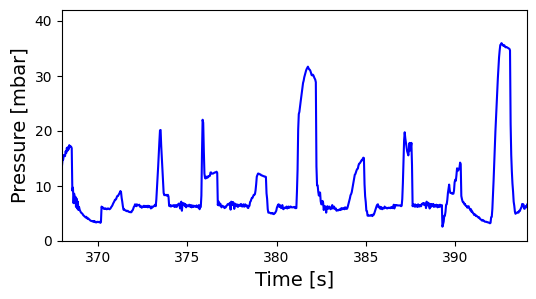

In [71]:
plt.figure(figsize=(6, 3))
plt.plot(np.linspace(0, len(test_y)*0.034035, len(test_y)), test_y*0.980665,color='blue')
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Pressure [mbar]", fontsize=14)
plt.xlim(368,394)
plt.ylim(0, 42)
#plt.legend()
#plt.show()
plt.savefig("output/ventilator_pressureinput_plot.pdf",bbox_inches='tight')

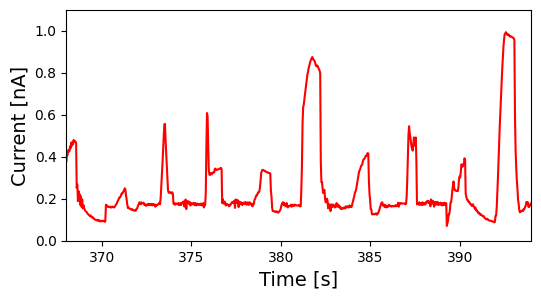

In [72]:
L = 200*10**-6
R = 25*10**-6
epsilon = (8.8541878128*10**-12)*80.23
eta = 0.001009347337765476 
psi0 = -0.04

plt.figure(figsize=(6, 3))
plt.plot(np.linspace(0, len(test_y)*0.034035, len(test_y)), -np.pi*(R**2)*epsilon*psi0*(test_y*0.980665*100)*10**9/(eta*L),color='red')
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Current [nA]", fontsize=14)
plt.xlim(368,394)
plt.ylim(0, 1.1)
#plt.legend()
#plt.show()
plt.savefig("output/ventilator_currentinput_plot.pdf",bbox_inches='tight')

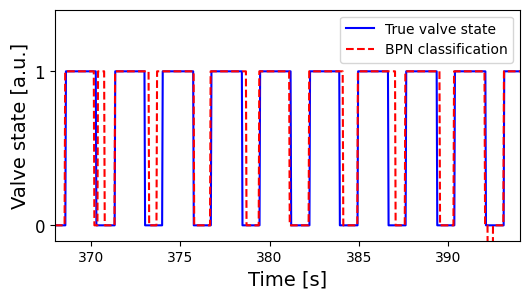

In [73]:
plt.figure(figsize=(6, 3))
plt.plot(np.linspace(0, len(test_y_uout)*0.034035, len(test_y_uout)), test_y_uout,color='blue', label="True valve state")
plt.plot(np.linspace(0, len(test_y[predict_steps:])*0.034035, len(test_y_uout)), predictions_uout,color='red', label="BPN classification", linestyle="--",)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Valve state [a.u.]", fontsize=14)
plt.yticks(np.arange(0,1.1,1),fontsize=12)
plt.xlim(368,394)
plt.ylim(-0.1,1.4)
plt.legend()
#plt.show()
plt.savefig("output/ventilator_plot_uout.pdf",bbox_inches='tight')

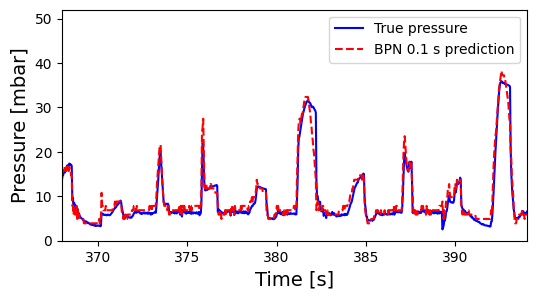

In [74]:
plt.figure(figsize=(6, 3))
plt.plot(np.linspace(0, len(test_y)*0.034035, len(test_y)), test_y*0.980665,color='blue', label="True pressure")
plt.plot(np.linspace(0, len(test_y[predict_steps:])*0.034035, len(test_y[predict_steps:])), predictions_p[predict_steps:]*0.980665,color='red', label="BPN 0.1 s prediction", linestyle="--",)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Pressure [mbar]", fontsize=14)
plt.xlim(368,394)
plt.ylim(0, 52)
plt.legend()
#plt.show()
plt.savefig("output/ventilator_plot_pressure.pdf",bbox_inches='tight')

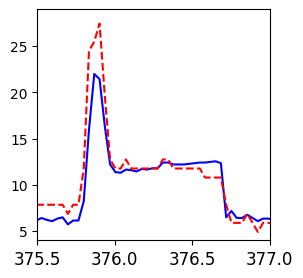

In [75]:
plt.figure(figsize=(3, 3))
plt.plot(np.linspace(0, len(test_y)*0.034035, len(test_y)), test_y*0.980665,color='blue')
plt.plot(np.linspace(0, len(test_y[predict_steps:])*0.034035, len(test_y[predict_steps:])), predictions_p[predict_steps:]*0.980665,color='red', linestyle="--",)
#plt.xlabel("Time [s]", fontsize=14)
#plt.ylabel("Pressure [mbar]", fontsize=14)
plt.xticks(np.arange(374,379,0.5),fontsize=12)
plt.xlim(375.5,377)
plt.ylim(4, 29)
#plt.show()
plt.savefig("output/ventilator_plot_zoom.pdf",bbox_inches='tight')

## PWDB

In [245]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
from ESN import PulseEchoStateNetwork, BandPassNetwork, PulseBandPassNetwork
import numpy as np
from sklearn.utils import shuffle
from tqdm import tqdm

In [247]:
pathlist = Path(r'data/pulse-wave-database/PWs_csv/csv').glob('**/*.csv')
dfs = []
for path in tqdm(pathlist):
    df = pd.read_csv(path)
    _, df["filename"], df["Type"] = path.name.split("_")
    df["Type"] = df["Type"].str.replace(r"\.csv$", "", regex=True)
    dfs.append(df)
final_df = pd.concat(dfs, ignore_index=True)
data = pd.read_csv(r'data\pulse-wave-database\m.csv')
data.index = data.index + 1
df = final_df.merge(data, left_on="Subject Number", right_index=True, how="left")
pulse_columns = [col for col in df.columns if col.startswith(" pt")]
df["pulse"] = df[pulse_columns].apply(lambda row: row.dropna().tolist(), axis=1)

# Drop the original pulse columns
df = df.drop(columns=pulse_columns)
df = df[df.Type == 'P']
df = df.dropna(subset=['SI'])
df = df.reset_index(drop=True)

52it [00:08,  5.94it/s]


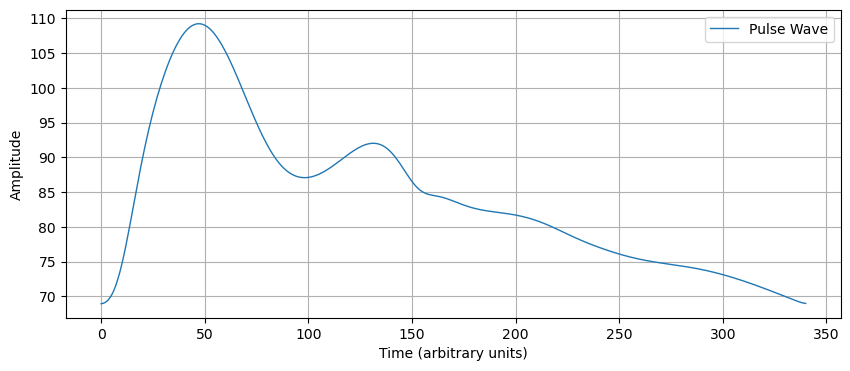

In [248]:
n = randint(0, len(df))
pulse_data = df.iloc[n]["pulse"]

plt.figure(figsize=(10, 4))
plt.plot(pulse_data, label="Pulse Wave", linewidth=1)
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Amplitude")
#plt.title(f"Pulse Waveform for {df.iloc[n]["filename"]} ({n})")
plt.legend()
plt.grid(True)
plt.show()

In [251]:
df_merged = df[["filename", "SI", "pulse"]].copy()
#df_merged["SI"]=(df_merged["SI"]-df_merged["SI"].min())/(df_merged["SI"].max()-df_merged["SI"].min())
df_merged = shuffle(df_merged, random_state=42)

train_samples = []
test_samples = []
num_samples = 300

unique_filenames = df_merged["filename"].unique()
for filename in unique_filenames:
    class_subset = df_merged[df_merged["filename"] == filename]

    train_samples.append(class_subset.iloc[:num_samples])
    test_samples.append(class_subset.iloc[num_samples:int(num_samples*1.2)])

train_set = pd.concat(train_samples).sample(frac=1, random_state=42)
test_set = pd.concat(test_samples).sample(frac=1, random_state=42)

train_x = list(train_set["pulse"])
train_y = train_set["SI"].values.reshape(-1, 1)
test_x = list(test_set["pulse"])
test_y = test_set["SI"].values.reshape(-1, 1)

In [ ]:
bpn = PulseBandPassNetwork(
    input_dim=1,
    reservoir_size=300,
    output_dim=1,
    leaking_rate=0.9,
    step_size=1,
    time_scale=200,
    time_scale_std=300,
    spectral_radius=0.4,
    sparsity=0.975,
    input_scaling=2.3758091737239763e-2,
    regularization=0.00047855525,
    washout = 3,
    guarantee_ESP=False,
    progress_bar=True,
)

bpn.fit(train_x, train_y)
predictions = bpn.predict(test_x)

This initilization has the echo state property


Training (pulses): 100%|██████████| 3900/3900 [00:44<00:00, 88.04it/s] 


In [279]:
mse(predictions - test_y)

9.520928740248218

One key detail is that in “pulses” mode, the code uses only the final reservoir state of each pulse to produce a single prediction. That single state often fails to capture large variations unless the reservoir is both large and driven strongly. In other words, if you have long pulses with strong peaks, reducing them to one final state makes the readout behave like an “average” of the pulse.

You can try the following adjustments:

Increase input scaling
A larger input_scaling can push reservoir states out of the mild range of tanh, leading to stronger dynamics.

Revisit guarantee_ESP
The Yildiz “guarantee” is conservative: it forces all initial reservoir weights to be nonnegative and then randomly flips signs. This dampens extremes. Try setting guarantee_ESP=False so weights have a more typical ESN distribution.

Use a bigger reservoir or smaller regularization
The final readout has to reconstruct the output from a single vector. If that vector is small or lacks variety, the predictions will be muted. A larger reservoir or weaker regularization (
𝜆
λ) can sometimes help.

Consider predicting multiple time steps
If your true target is a whole time series (with large peaks) rather than a single scalar per pulse, try the “timestep” mode. That way the readout can adapt at each time step and will not compress entire pulses into one state.

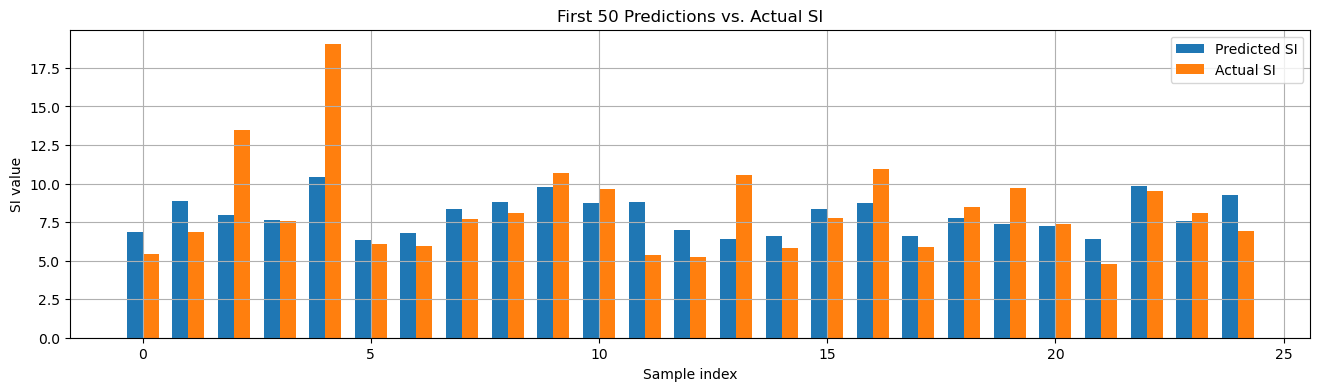

In [284]:
predictions = np.asarray(predictions).ravel()
test_y = np.asarray(test_y).ravel()

n = 25
indices = np.arange(n)
width = 0.35

plt.figure(figsize=(16, 4))
plt.bar(indices - width/2, predictions[:n], width=width, label='Predicted SI')
plt.bar(indices + width/2, test_y[:n], width=width, label='Actual SI')
plt.title('First 50 Predictions vs. Actual SI')
plt.xlabel('Sample index')
plt.ylabel('SI value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_merged = df[["filename", "SI", "pulse"]].copy()
#df_merged["SI"]=(df_merged["SI"]-df_merged["SI"].min())/(df_merged["SI"].max()-df_merged["SI"].min())
df_merged = shuffle(df_merged, random_state=42)

train_samples = []
test_samples = []
num_samples = 100

unique_filenames = df_merged["filename"].unique()
for filename in unique_filenames:
    class_subset = df_merged[df_merged["filename"] == filename]

    train_samples.append(class_subset.iloc[:num_samples])
    test_samples.append(class_subset.iloc[num_samples:int(num_samples*1.2)])

train_set = pd.concat(train_samples).sample(frac=1, random_state=42)
test_set = pd.concat(test_samples).sample(frac=1, random_state=42)

train_x = list(train_set["pulse"])
train_y = train_set["SI"].values.reshape(-1, 1)
test_x = list(test_set["pulse"])
test_y = test_set["SI"].values.reshape(-1, 1)

In [ ]:
esn_loc = PulseEchoStateNetwork(
    input_dim=1,
    reservoir_size=1000,
    output_dim=1,
    leaking_rate=0.9,
    step_size=1,
    time_scale=75,
    spectral_radius=0.4,
    sparsity=0.9,
    input_scaling=2.3758091737239763e-6,
    regularization=0.00047855525,
    washout = 3,
    guarantee_ESP=False,
    progress_bar=True,
)

esn_loc.fit(train_x, train_y)
predictions = esn_loc.predict(test_x)